# 1. Contextualisation du projet

Nous travaillons pour une compagnie d'assurance santé privée.

## Problématique:
Comment notre compagnie d'assurance santé privée peut-elle estimer de manière fiable les charges médicales futures de ses clients afin d'ajuster ses primes d'assurance tout en garantissant l'équité et la soutenabilité financière du système?

## Contrainte: 
**Ne pas discriminer des individus sur des critères sensibles (ex: sexe, tabagisme, age).**

Notre modèle doit :
- **Respecter les règles d'équité (fairness)**: pas de discrimination arbirtraire entre les individus.
- **Garder une transparence sur les décisions**: expliquer pourquoi une prime d'assurance est élevée pour un individu.
- **Etre robuste aux biais** introduits par les données (ex. biais historique contre les fumeurs ou les personnes agées).

# 2. Objectifs du projet
- MAE et RMSLE les plus faible possible.
- **Et surtout une erreur moyenne par sous groupe (fumeur vs non-fumeur, homme vs femme) qui est stable**.
- Pouvoir interpréter les résultats pour expliquer pourquoi une prédiction est élevée et garantir la confiance des clients et des régulatuers.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Medical cost.csv")
data = df.copy()
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


In [3]:
data.shape

(1338, 7)

# 3. EDA

### Objectif de l'EDA:
Comprendre au maximum les données dont on dispose pour définir une stratégie de modélisation.

### Checklist  :

### Analyse de la forme :
- **Identification de la target**: charges
- **Nombre de lignes et de colonnes**: 1338 lignes, 7 colonnes
- **Types de variables**: Qualitatives (region, smoker et sexe),    Quantitatives (age, BMI, children, charges)
- **Identification des valeurs manquantes**: age(9), bmi(6), children(7).

### Analyse du fond :
- **Visualisation de la target:** Asymétrie de la distribution des charges médicales.
- **Compréhension des différentes variables:**
    - Age: age des individus
    - Sex: homme ou femme
    - bmi: indice de masse corporelle
    - children: nombre d'enfants
    - smoker: fumeur (1 pour oui et 0 pour non)
    - region: region du domicile
    - charges: charges médicales
- **Visualisation des différentes variables:** Quali (il n'y a que smoker qui est déséquilibré); Quanti(l'age présente une distribution quasi uniforme, le bmi a une distribution presque normale.)
- **Visualisation des relations entre features-target**
    - **Quanti/target**: Aucune corrélation forte (la plus grande etant à 0.29)
    - **Quali/target**: les charges ont une moyenne significativement différente selon qu'on se trouve chez les fumeurs et chez les non fumeurs, les charges ont une moyenne identique selon qu'on se trouve chez les hommes et chez les femmes (Hypothèses à tester). D'un autre coté, il semble que la moyenne des charges médicales ne varie pas significativement entre les regions (hypothèse à tester également).
- **Visualisation des relations variables-variables**:
    - **Quanti/quanti**: Aucune corrélation forte ni moyenne
    - **Quali/quali**: RAS, les tableux croisés indiquent qu'aucune variable catégorielle n'a d'influence sur une autre
    - **Quali(smoker)/quanti**: RAS, l'age, le bmi et le nombre d'enfants n'ont probablement rien à voir avec le fait qu'une personne fume ou pas.

- **Identification des outliers:** RAS
- **Tests statistiques**:
    - **ANOVA** pour region/charges (pas pour le moment)
    - **Student** pour smoker/charges et sex/charges. H0: La moyenne des charges ne varie pas selon qu'on se situe chez les hommes ou chez les femmes; chez les fumeurs ou chez les non-fumeurs. **Résultats**: H0 est rejété pour smokers et pas pour sexe. Donc le fait de fumer influence les charges médicales et le sexe pas.


### Analyse de la forme

In [4]:
# types de variables
data.dtypes

age         float64
sex          object
bmi         float64
children    float64
smoker       object
region       object
charges     float64
dtype: object

In [5]:
# Valeurs manquantes
data.isna().sum()

age         9
sex         0
bmi         6
children    7
smoker      0
region      0
charges     0
dtype: int64

### Analyse du fond

<Axes: xlabel='charges'>

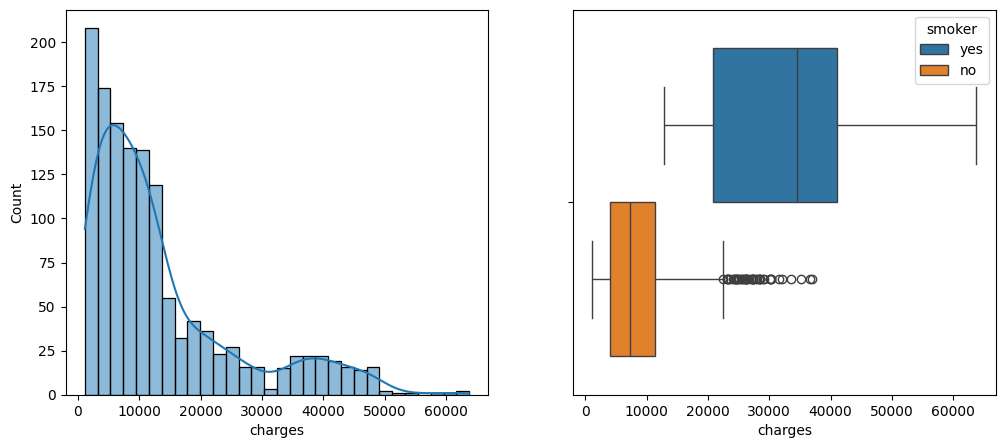

In [26]:
# visualisation de la target
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data['charges'], kde=True)

plt.subplot(1, 2, 2)
sns.boxplot(data=data, x=data['charges'], hue='smoker')

La distribution 👆👆 des charges médicales est **asymétrique**. Cela suggère que:

- Un modèle linéaire simple qui suppose la normalité des erreurs ne peut potentiellement pas etre utilisé.
- Une **transformation logaritmique** peut potentiellement etre utile dans notre situation.

<Axes: xlabel='charges', ylabel='Count'>

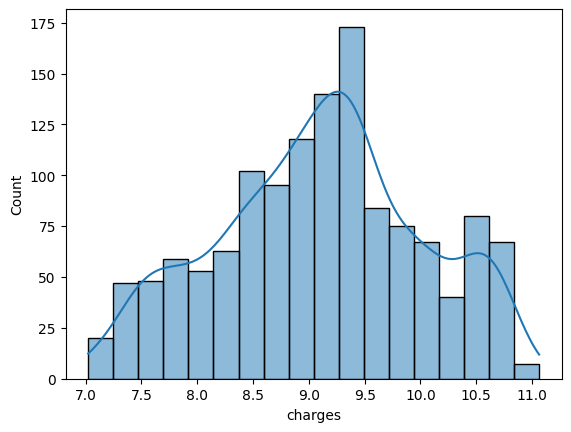

In [7]:
charges = data['charges']
log = np.log(charges)
sns.histplot(log, kde=True)

In [8]:
# visualisation des différentes variables

# creation des mini datasets 
femmes = data[data['sex'] == 'female']
hommes = data[data['sex'] == 'male']

fumeurs = data[data['smoker'] == 'yes']
non_fumeurs = data[data['smoker'] == 'no']

In [9]:
# visualisation des différentes variables
for col in data.select_dtypes('object'):
    print(f'{col:-<30} {data[col].unique()}')


sex--------------------------- ['female' 'male']
smoker------------------------ ['yes' 'no']
region------------------------ ['southwest' 'southeast' 'northwest' 'northeast']


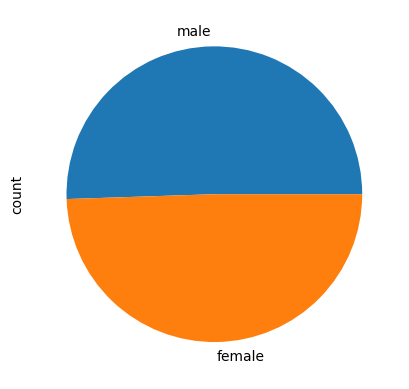

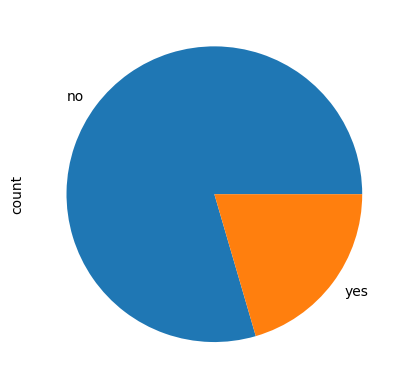

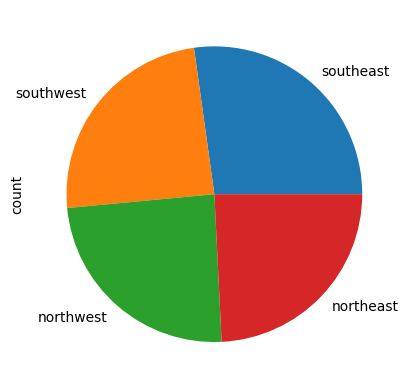

In [10]:
# visualisation des différentes variables
for col in data.select_dtypes('object'):
    plt.figure()
    data[col].value_counts().plot.pie()


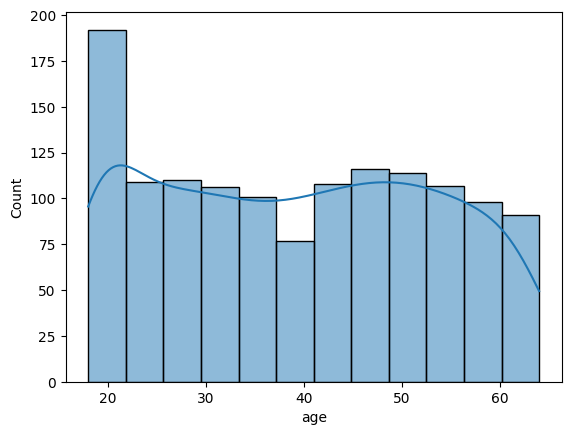

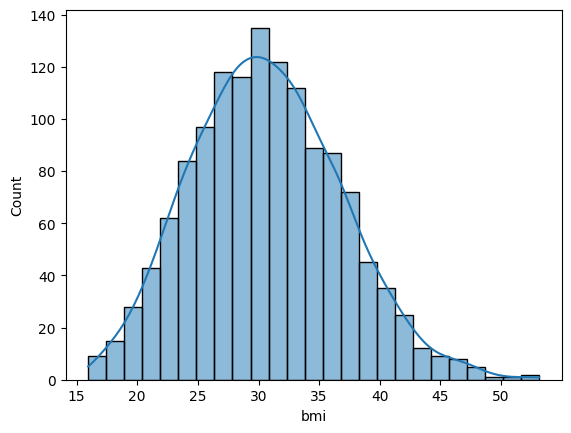

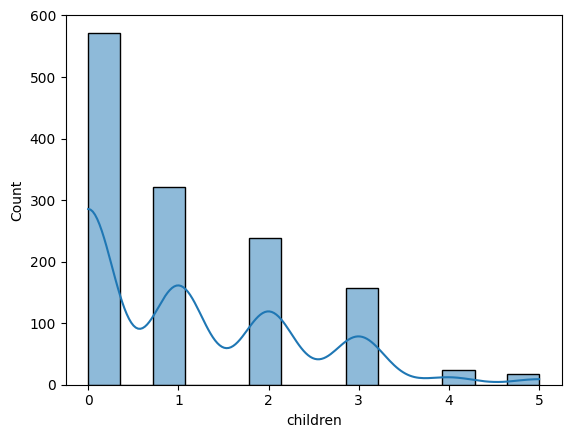

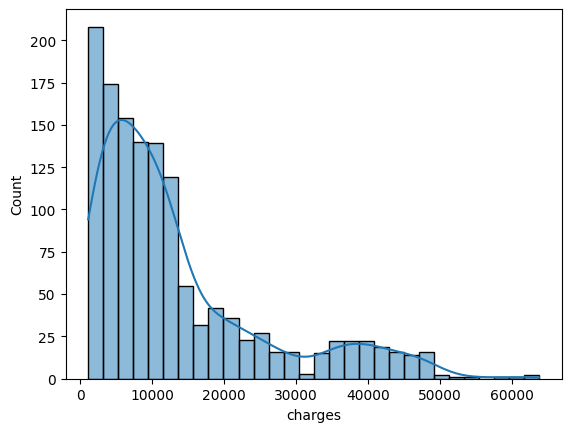

In [11]:
# visualisation des différentes variables
for col in data.select_dtypes(include=['number']):
    plt.figure()
    sns.histplot(data[col], kde=True)


#### Relations variables/target

In [12]:
# Relations quanti/ target
data.select_dtypes(include=['number']).corr()['charges'].sort_values()

children    0.068271
bmi         0.201110
age         0.299312
charges     1.000000
Name: charges, dtype: float64

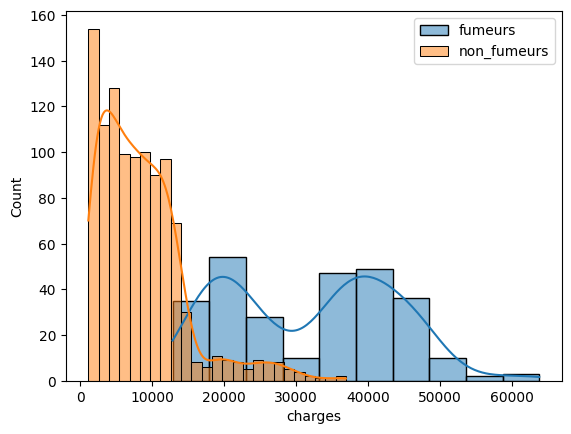

In [13]:
# Relations quali target

# Fumeurs/charges
plt.figure()
sns.histplot(fumeurs['charges'], kde=True, label='fumeurs')
sns.histplot(non_fumeurs['charges'], kde=True, label='non_fumeurs')
plt.legend()
plt.show()

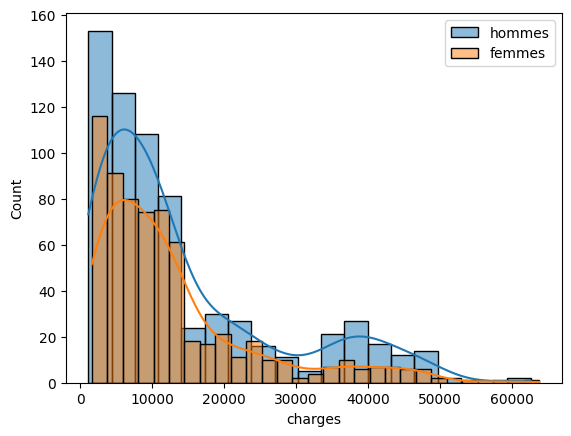

In [14]:
# sexe/charges
plt.figure()
sns.histplot(hommes['charges'], kde=True, label='hommes')
sns.histplot(femmes['charges'], kde=True, label='femmes')
plt.legend()
plt.show()

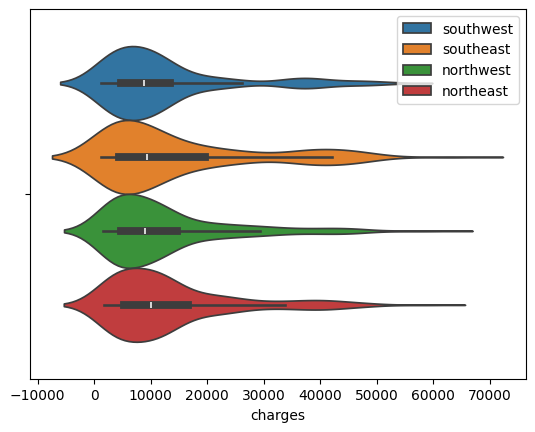

In [15]:
# regions/charges
plt.figure()
sns.violinplot(data=data, x=data['charges'], hue='region')
plt.legend()
plt.show()

### Relations variables/ variables

<Figure size 800x500 with 0 Axes>

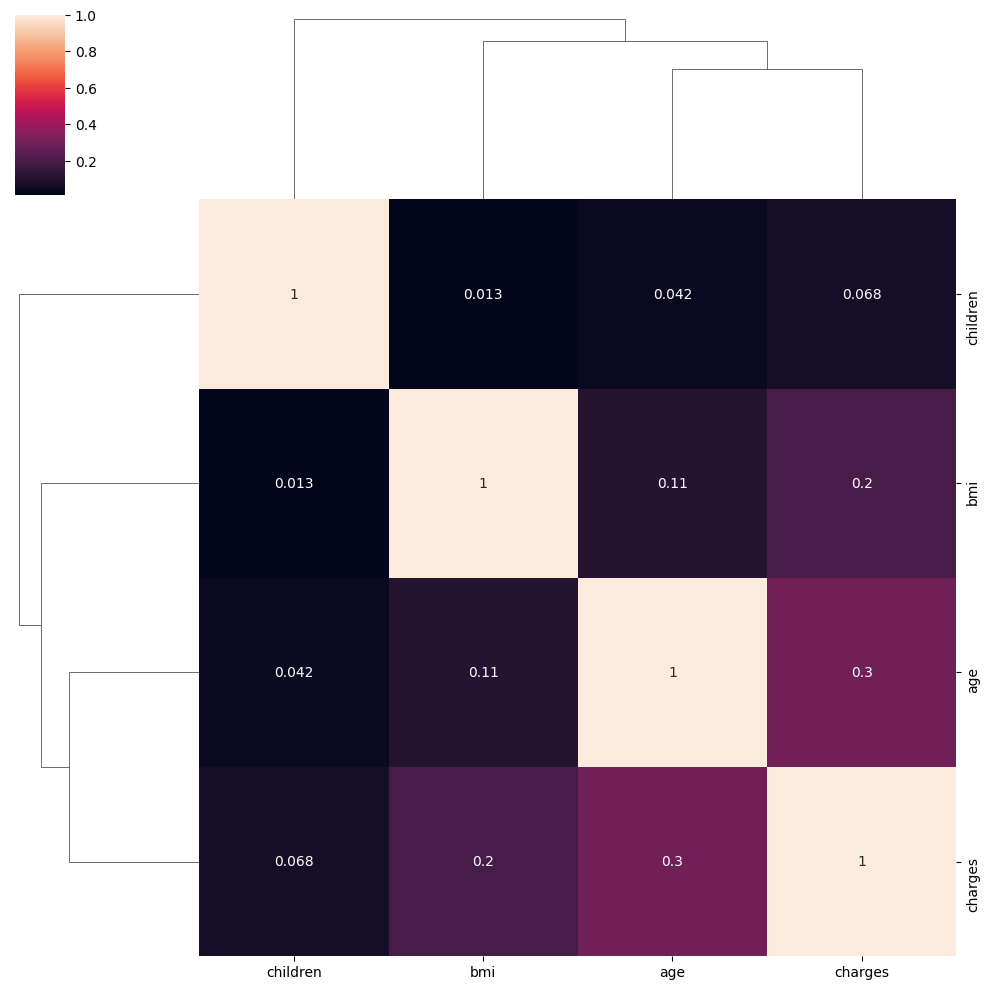

In [16]:
# Relations entre les variables quantitatives
plt.figure(figsize=(8, 5))
sns.clustermap(data.select_dtypes(include=['number']).corr(), annot=True)

In [17]:
# Relations entre variables qualitatives
# sex/region
pd.crosstab(data['region'], data['sex'])

sex,female,male
region,,
northeast,161,163
northwest,164,161
southeast,175,189
southwest,162,163


In [18]:
# smoker/region
pd.crosstab(data['region'], data['smoker'])

smoker,no,yes
region,,
northeast,257,67
northwest,267,58
southeast,273,91
southwest,267,58


In [19]:
# smoker/sex
pd.crosstab(data['smoker'], data['sex'])

sex,female,male
smoker,,
no,547,517
yes,115,159


C:\Users\DELL\AppData\Local\Temp\ipykernel_53252\61930779.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=data['smoker'], y=data[col], palette='Set2')
C:\Users\DELL\AppData\Local\Temp\ipykernel_53252\61930779.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=data['smoker'], y=data[col], palette='Set2')
C:\Users\DELL\AppData\Local\Temp\ipykernel_53252\61930779.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=data['smoker'], y=data[col], palette='Set2')


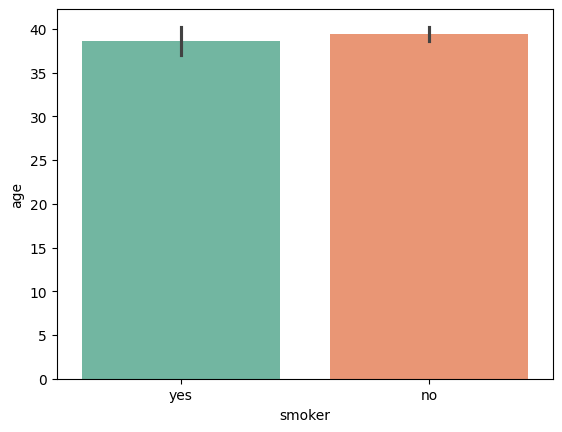

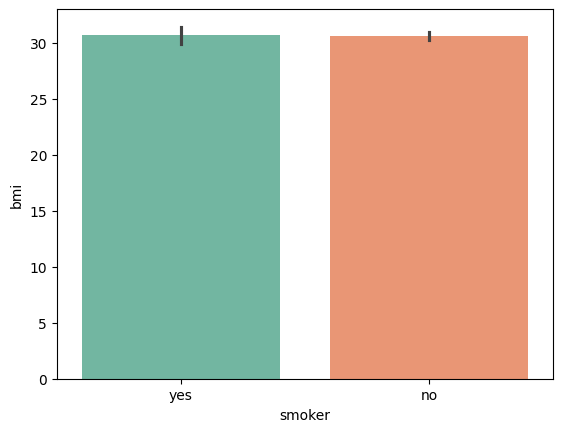

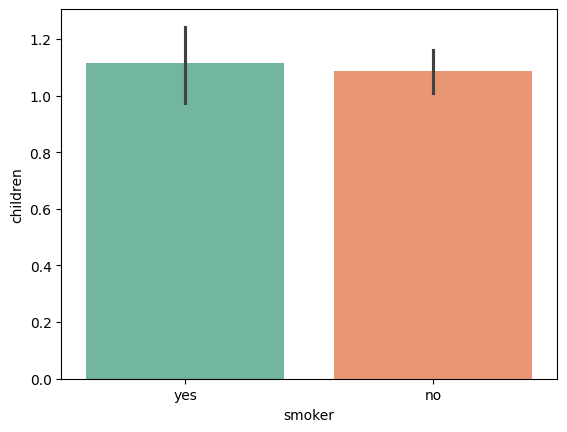

In [20]:
# Relations quanti/smoker
for col in data.select_dtypes(include=['number']).drop('charges', axis=1):
    plt.figure()
    sns.barplot(data=data, x=data['smoker'], y=data[col], palette='Set2')

### Identification des outliers

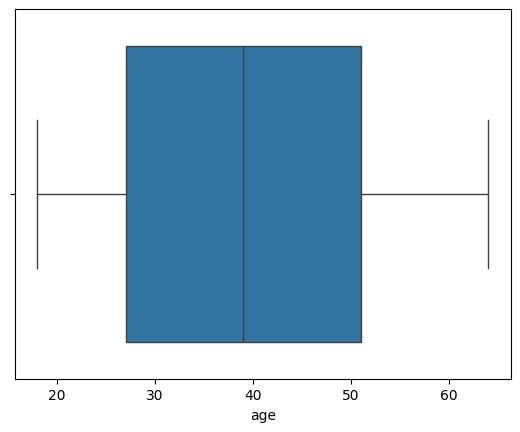

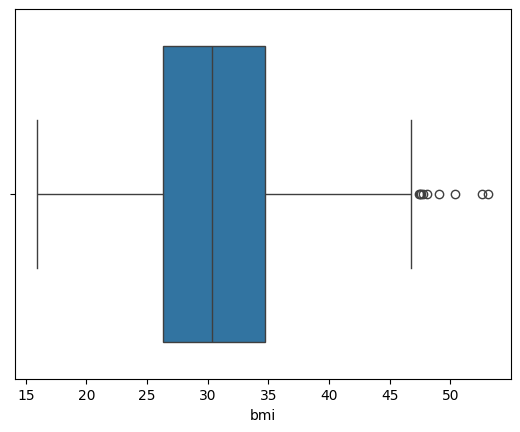

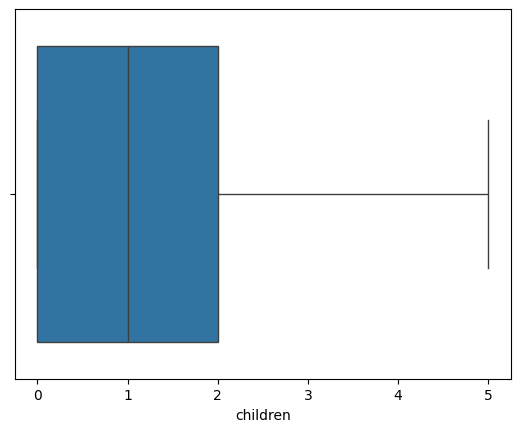

In [21]:
for col in data.select_dtypes(include=['number']).drop('charges', axis=1):
    plt.figure()
    sns.boxplot(data=data, x=data[col])

### T-Test

In [22]:
from scipy.stats import ttest_ind

In [23]:
# dimensions des mini-datasets pour le test
non_fumeurs_balanced = non_fumeurs.sample(fumeurs.shape[0]) # pour un dest statistiques les deux modalités doivent avoir les memes dimensons

In [24]:
# fonction pour le test de student
def student_smokers(col):
    alpha= 0.02
    stat, p = ttest_ind(fumeurs[col].dropna(), non_fumeurs_balanced[col].dropna())

    if p < alpha:
        return 'H0 Rejétée'
    else:
        return 0


def student_sex(col):
    alpha= 0.02
    stat, p = ttest_ind(hommes[col].dropna(), femmes[col].dropna())

    if p < alpha:
        return 'H0 Rejétée'
    else:
        return 0

In [25]:
# Résultats des tests
print(f"smokers----------- {student_smokers('charges')}")
print(f"sex--------------- {student_sex('charges')}")

smokers----------- H0 Rejétée
sex--------------- 0
